# Data Storage Format

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Spreadsheet-Analogy" data-toc-modified-id="Spreadsheet-Analogy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Spreadsheet Analogy</a></span></li><li><span><a href="#Dictionaries-and-Numpy-Arrays" data-toc-modified-id="Dictionaries-and-Numpy-Arrays-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dictionaries and Numpy Arrays</a></span><ul class="toc-item"><li><span><a href="#Quick-Overview-of-Dictionaries" data-toc-modified-id="Quick-Overview-of-Dictionaries-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Quick Overview of Dictionaries</a></span></li><li><span><a href="#Quick-Overview-of-Numpy-Arrays" data-toc-modified-id="Quick-Overview-of-Numpy-Arrays-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Quick Overview of Numpy Arrays</a></span></li><li><span><a href="#Rules-to-Maintain-Data-Integrity" data-toc-modified-id="Rules-to-Maintain-Data-Integrity-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Rules to Maintain Data Integrity</a></span></li></ul></li><li><span><a href="#Representing-Topology" data-toc-modified-id="Representing-Topology-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Representing Topology</a></span><ul class="toc-item"><li><span><a href="#Storage-of-Topological-Connections" data-toc-modified-id="Storage-of-Topological-Connections-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Storage of Topological Connections</a></span></li><li><span><a href="#Sparse-Adjacency-Matrices" data-toc-modified-id="Sparse-Adjacency-Matrices-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Sparse Adjacency Matrices</a></span></li><li><span><a href="#Additional-Thoughts-on-Sparse-Storage" data-toc-modified-id="Additional-Thoughts-on-Sparse-Storage-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Additional Thoughts on Sparse Storage</a></span></li></ul></li></ul></div>

In [1]:
import openpnm as op
import numpy as np
np.random.seed(0)

## Spreadsheet Analogy

The best analogy for explaining data storage in OpenPNM is the humble spreadsheet.  According to this analogy, each pore (or throat) corresponds to a row and each property corresponds to a column.

Consider the following network with 4 pores, 3 throats:

In [2]:
pn = op.network.Cubic(shape=[4, 1, 1])
geo = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)

Let's use ``pandas`` to express the geometric properties as a 'spreadsheet':

In [3]:
import pandas as pd
pore_data_sheet = pd.DataFrame({i: geo[i] for i in geo.props(element='pore')})

We can now view this 'spreadsheet':

In [4]:
print(pore_data_sheet)

   pore.volume  pore.diameter  pore.area  pore.seed  pore.max_size
0     0.055905       0.474407   0.176763   0.474407            1.0
1     0.090773       0.557595   0.244190   0.557595            1.0
2     0.065994       0.501382   0.197436   0.501382            1.0
3     0.055213       0.472442   0.175302   0.472442            1.0


The properties are the 'column' names, such as 'pore.area', and the rows correspond to the pore index, so 'pore 0' has an area of 0.176763.  

One could also extract an entire column using:

In [5]:
pore_area_column = pore_data_sheet['pore.area']
print(pore_area_column)

0    0.176763
1    0.244190
2    0.197436
3    0.175302
Name: pore.area, dtype: float64


And then access individual elements:

In [6]:
print(pore_area_column[0])

0.17676309790984798


## Dictionaries and Numpy Arrays

Although the spreadsheet analogy described above is very close to reality, OpenPNM does not actually use ``pandas`` DataFrames, or any other spreadsheet data structure.  Instead, it uses the basic Python *dictionary* and Numpy arrays to accomplish a nearly identical behavior, but with a bit more flexibility.

Each OpenPNM object (e.g. networks, algorithms, etc) is actually a customized (a.k.a. [subclassed](https://realpython.com/python-data-classes/#inheritance)) Python [*dictionary*](https://realpython.com/python-dicts/) which allows data to be stored and accessed by name, with a syntax like ``network['pore.diameter']``.  This is analogous (actually indistinguishable) to extracting a column from a spreadsheet as outlined above.  Once the data array is retrieved from the dictionary, it is then a simple matter of working with a Numpy array, which use familiar array indexing, so the diameter of pore 0 is found be accessing element 0 of the array stored under the 'pore.diameter' key.  This is elaborated upon below.

### Quick Overview of Dictionaries
The internet contains many tutorials on Python "dicts".  To summarize, they are general purpose data contains where *items* can be stored by name, as follows:

In [7]:
a = {}  # Create an empty dict
a['item 1'] = 'a string'
a['item 2'] = 4  # a number
a['another item'] = {}  # Even other dicts!
print(a)

{'item 1': 'a string', 'item 2': 4, 'another item': {}}


Data can be accessed by name, which is called a "key":

In [8]:
print(a['item 2'])

4


And all keys on a given dictionary can be retrieved as a list:

In [9]:
print(a.keys())

dict_keys(['item 1', 'item 2', 'another item'])


### Quick Overview of Numpy Arrays

OpenPNM uses *dictionaries* or `dict`'s to store an assortment of [Numpy arrays](https://docs.scipy.org/doc/numpy/user/) that each contain a specific type of pore or throat data.  

There are many [tutorials](https://realpython.com/numpy-array-programming/) on the internet explaining the various features and benefits of Numpy arrays.  To summarize, they are familiar to numerical arrays in any other language.  

Let's extract a Numpy array from the ``geo`` object and play with it:

In [10]:
a = geo['pore.diameter']
print(a)

[0.47440675 0.55759468 0.50138169 0.47244159]


It's possible to extract several elements at once:

In [11]:
a[1:3]

array([0.55759468, 0.50138169])

And easy to multiply all values in the array by a scalar or by another array of the same size, which defaults to element-wise multiplication:

In [12]:
print(a*2)

[0.9488135  1.11518937 1.00276338 0.94488318]


In [13]:
print(a*a)

[0.22506177 0.31091183 0.2513836  0.22320106]


### Rules to Maintain Data Integrity

Several rules have been implemented to control the integrity of the data:
* Only Numpy arrays can be stored in an OpenPNM object, and any data that is written into one of the OpenPNM object dicionaries will be converted to a Numpy array.  This is done to ensure that all mathematically operations throughout the code can be consistently done using vectorization.  Note that any subclasses of Numpy arrays, such as Dask arrays or Unyt arrays are also acceptable.
* All array names must begin with either *'pore.'* or *'throat.'* which serves to identify the type of information they contain.
* For the sake of consistency only arrays of length *Np* or *Nt* are allowed in the dictionary. Assigning a scalar value to a dictionary results in the creation of a full length vector, either *Np* or *Nt* long, depending on the name of the array..  This effectively applies the scalar value to all locations in the network.
* Any Boolean data will be treated as a *label* while all other numerical data is treated as a *property*. 

## Representing Topology

### Storage of Topological Connections

Pore network modeling is actually just a form of graph theory.  

> During the development of OpenPNM, it was debated whether existing Python graph theory packages (such as [graph-tool](http://graph-tool.skewed.de/) or [NetworkX](http://networkx.github.io/) should be used to store the network topology.  It was decided that network property data should be simply stored as [Numpy ND-arrays](http://www.numpy.org/) as discussed above.  This format makes the data storage very transparent and familiar since all engineers are used to working with arrays (i.e. vectors), and also very efficiently since this allows code vectorization.  Fortuitously, around the same time as this discussion, Scipy introduced the [compressed sparse graph library](http://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html), which contains numerous graph theory algorithms that take Numpy arrays as arguments.  Therefore, OpenPNM's topology model is implemented using Numpy arrays, which is described in detail below:

The only topology definitions required by OpenPNM are:

1. A throat connects exactly two pores, no more and no less

2. Throats are non-directional, meaning that flow in either direction is equal

Other general, but non-essential rules are:

3. Pores can have an arbitrary number of throats, including zero; however, pores with zero throats lead to singular matrices and other problems so should be avoided.

4. Two pores are generally connected by no more than one throat.  It is technically possible in OpenPNM to have multiple throats between a pair of pores, but it is not rigorosly supported so unintended results may arise.

### Sparse Adjacency Matrices

In OpenPNM network topology (or connectivity) is stored as an [adjacency matrix](http://en.wikipedia.org/wiki/Adjacency_matrix).  An adjacency matrix is a *Np*-by-*Np* 2D matrix.  A non-zero value at location (*i*, *j*) indicates that pores *i* and *j* are connected.  Describing the network in this general fashion allows OpenPNM to be agnostic to the type of network it describes.  Another important feature of the adjacency matrix is that it is highly sparse and can be stored with a variety of sparse storage schemes.  OpenPNM stores the adjacency matrix in the 'COO' or 'IJV' format, which essentially stores the coordinates (I,J) and values (V) of the nonzero elements in three separate lists.  This approach results in a property called ``'throat.conns'``; it is an *Nt*-by-2 array that gives the index of the two pores on either end of a given throat.  The representation of an arbitrary network is shown in the following figure. It has 5 pores and 7 throats, and the ``'throat.conns'`` array contains the (I,J,V) information to describes the adjacency matrix.


In [21]:
def plot_network(pn, font_size=24, line_width=3, node_color='b', edge_color='r', node_size=2000):
    import openpnm as op
    import networkx as nx
    import matplotlib.pyplot as plt
    G = op.io.NetworkX.to_networkx(network=pn)
    pos = {i: pn['pore.coords'][i, 0:2] for i in pn.Ps}
    labels = {i: i for i in pn.Ps}
    edge_labels = {tuple(pn['throat.conns'][i, :]): i for i in pn.Ts}
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='w', edgecolors=node_color, linewidths=line_width)
    nx.draw_networkx_edges(G, pos, width=line_width, edge_color=edge_color)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=font_size, font_color='k')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=font_size, font_color='k')
    plt.axis('off')

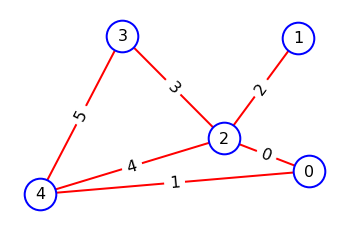

In [124]:
np.random.seed(10)
pts = np.random.rand(5, 2)*1.5
pn = op.network.Delaunay(points=pts, shape=[1, 1, 0])
plot_network(pn, line_width=2, font_size=16, node_color='b', node_size=1000)

### Additional Thoughts on Sparse Storage

* In pore networks there is (usually) no difference between traversing from pore *i* to pore *j* or from pore *j* to pore *i*, so a 1 is also found at location (*j*, *i*) and the matrix is symmetrical.

* Since the adjacency matrix is symmetric, it is redundant to store the entire matrix when only the upper triangular part is necessary.  The ``'throat.conns'`` array only stores the upper triangular information, and *i* is always less than *j*.

* Although this storage scheme is widely known as *IJV*, the ``scipy.sparse`` module calls this the Coordinate or *COO* storage scheme.

* Some tasks are best performed on other types of storages scheme, such as *CSR* or *LIL*.  OpenPNM converts between these internally as necessary, but users can generate a desired format using the ``create_adjacency_matrix`` method which accepts the storage type as an argument (i.e. ``'csr'``, ``'lil'``, etc).  For a discussion of sparse storage schemes and the respective merits, see this [Wikipedia article](http://en.wikipedia.org/wiki/Sparse_matrix).